In [1]:
import pandas as pd
import numpy as np
import glob
%config IPCompleter.use_jedi=False

from sklearn.model_selection import train_test_split

## IDEAS

First split into train,validation,and Test before even plotting the data.
(How large should each data set be?)
Only plot training data, neve rlook at test data! Otherwise my your knowledge of test data biases test error estimates.

Is data set "Balanced"? Should I try to preserve some balance in train, val, test split?
-> Subscribers make MANY more trips

Remove outliers from triptime and birthyear data

1. Load all files into one data frame grouped by month -> Can pandas even do this?
2. Split Data -> I do one fixed train,test,validation split at the beginning and never change it because the data set is very large and I dont expect much variation over splits. I could otherwise do corss-validation or something. Question: Should one balance labels somehow in the splits?
3. Compute trip durations -> already done, and length (how??? luftlinie oder station distances -> Google maps API?) from the data
    1. Can use OSMnx
    2. Use Taxicab metric (simpler) -> Actually not simpler at all, need coordinates relative to new york layout
    3. Luftlinie (am einfachsten)
4. Compute weekdays vs weekends
5. Can one do somethign with bikeID?
6. Can one do something with stationID?
7. Compare to baseline of simply choosing most likely class label, ignoring user data!
   Or use other ways of dealing with imbalance / representing effect?

Features need to be preprocessed -> Encode categorically etc.

Some feature ideas:
1. Time
2. Distance
3. Speed
4. Workday vs Weekend (maybe even include holidays)
5. Month (maybe)
6. StartStation -> Because people from similar areas might be subscribers / not 

## Evaluation?

1. Evaluate vs baseline (baseline = always choos "subscriber" as label)
2. Confusion matrix

## Data Cleaning

Try loading the whole dataset. Note that this needs more than 9 GB of memory.

In [2]:
filenames = glob.glob("Data/2*.csv")
print(filenames)
dfs = []
for filename in filenames:
    month = filename[9:11]
    print(month)
    d = pd.read_csv(filename)
    d["month"] = month    
    dfs.append(d)
data = pd.concat(dfs,ignore_index=True)

['Data/201810-citibike-tripdata.csv', 'Data/201802-citibike-tripdata.csv', 'Data/201809-citibike-tripdata.csv', 'Data/201808-citibike-tripdata.csv', 'Data/201803-citibike-tripdata.csv', 'Data/201807-citibike-tripdata.csv', 'Data/201812-citibike-tripdata.csv', 'Data/201805-citibike-tripdata.csv', 'Data/201811-citibike-tripdata.csv', 'Data/201806-citibike-tripdata.csv', 'Data/201804-citibike-tripdata.csv', 'Data/201801-citibike-tripdata.csv']
10
02
09
08
03
07
12
05
11
06
04
01


In [3]:
data

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,month
0,330,2018-10-01 00:00:00.7010,2018-10-01 00:05:30.8490,293.0,Lafayette St & E 8 St,40.730207,-73.991026,504.0,1 Ave & E 16 St,40.732219,-73.981656,30493,Subscriber,1995,1,10
1,309,2018-10-01 00:00:13.5780,2018-10-01 00:05:23.2310,433.0,old - E 13 St & Avenue A,40.729554,-73.980572,394.0,E 9 St & Avenue C,40.725213,-73.977688,33054,Subscriber,1967,1,10
2,734,2018-10-01 00:00:16.6040,2018-10-01 00:12:31.5050,3472.0,W 15 St & 10 Ave,40.742754,-74.007474,285.0,Broadway & E 14 St,40.734546,-73.990741,33400,Subscriber,1983,2,10
3,788,2018-10-01 00:00:35.0670,2018-10-01 00:13:43.5780,417.0,Barclay St & Church St,40.712912,-74.010202,3472.0,W 15 St & 10 Ave,40.742754,-74.007474,31140,Customer,1988,1,10
4,1136,2018-10-01 00:00:38.1410,2018-10-01 00:19:34.6490,3699.0,W 50 St & 9 Ave,40.763605,-73.989180,495.0,W 47 St & 10 Ave,40.762699,-73.993012,20294,Subscriber,1969,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17548334,843,2018-01-31 17:28:27.5390,2018-01-31 17:42:30.5890,3664.0,North Moore St & Greenwich St,40.720195,-74.010301,410.0,Suffolk St & Stanton St,40.720664,-73.985180,15153,Subscriber,1981,1,01
17548335,244,2018-01-31 17:34:20.4510,2018-01-31 17:38:24.7200,3664.0,North Moore St & Greenwich St,40.720195,-74.010301,327.0,Vesey Pl & River Terrace,40.715338,-74.016584,26896,Subscriber,1960,1,01
17548336,302,2018-01-31 18:20:55.5430,2018-01-31 18:25:58.3350,3664.0,North Moore St & Greenwich St,40.720195,-74.010301,327.0,Vesey Pl & River Terrace,40.715338,-74.016584,33111,Subscriber,1965,1,01
17548337,222,2018-01-31 18:47:42.5720,2018-01-31 18:51:24.6830,3664.0,North Moore St & Greenwich St,40.720195,-74.010301,257.0,Lispenard St & Broadway,40.719392,-74.002472,16675,Subscriber,1969,0,01


In [4]:
memory = data.memory_usage(index=True,deep=True).sum()
print(f"The dataframe needs {memory/1e9:.3} GB of memory")

The dataframe needs 9.14 GB of memory


We now look at the some features and try to remove outliers.

First, lets check for NAN values:

In [5]:
data.count()

tripduration               17548339
starttime                  17548339
stoptime                   17548339
start station id           17545842
start station name         17545842
start station latitude     17548339
start station longitude    17548339
end station id             17545842
end station name           17545842
end station latitude       17548339
end station longitude      17548339
bikeid                     17548339
usertype                   17548339
birth year                 17548339
gender                     17548339
month                      17548339
dtype: int64

We see that start and end station ids and names are not always available.
This affects about 3000 of the 17 million entries.
We simply remove the rows with missing values.

In [6]:
data.dropna(inplace=True)
print(len(data))
data.count()

17545842


NameError: name 'data_cleaned' is not defined

Now, we check for outliers in the different features.
Let us start with trip durations.
We plot a histogram of the tripdurations to understand the distributions.
Because there are some very large values, we use a loglog-scale.
Note that the bins should be spaced evenly on a log-scale and not on a linear scale, so we specify them manually.

Text(0.5, 0, 'Duration (s)')

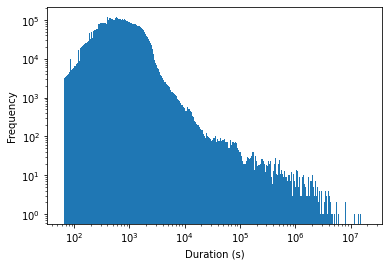

In [7]:
min_dur = data["tripduration"].min()
max_dur = data["tripduration"].max()
n_bins = 1000
bins = np.logspace(start = np.log10(min_dur),stop = np.log10(max_dur),num=n_bins)
ax = data["tripduration"].plot(kind="hist",loglog=True,bins=bins)
ax.set_xlabel("Duration (s)")

In [20]:
1e7 / (60*60*24)

115.74074074074075

Most trips are between 2 mins and 1 hour.
We remove trip durations > 5 hours, which is about $2\cdot10^4$ seconds.
Also note that durations < 60 seconds were already removed by the data provider, reasoning that these are likely just people trying to redock the bike. Therefore, we will not remove any more small trip lengths.

In [8]:
duration_h = 5
longtrips = data[data["tripduration"] >= duration_h*60*60]
print(f"There are {len(longtrips)} trips of at least {duration_h} hours in the data.")
data.drop(longtrips.index,inplace=True)

There are 15454 trips of at least 5 hours in the data.


Next, lets have a look at the birthyears.

In [9]:
print(data["birth year"].min())
print(data["birth year"].max())

1885
2002


We will exclude people born before 1920, since the data is from 2018.

In [11]:
old = data[data["birth year"] <= 1920]
print(f"There are {len(old)} trips made by people born before 1920 in the data.")
data.drop(old.index,inplace=True)

There are 181920 trips made by people born before 1920 in the data.


Next, we look at the coordinates.
New york encompasses latitudes of about between 40.6 and 40.9, and longitudes between -74.2 and -73.7

In [26]:
print(data["start station latitude"].min())
print(data["start station latitude"].max())

40.64653836709648
45.506364054011385


<AxesSubplot:ylabel='Frequency'>

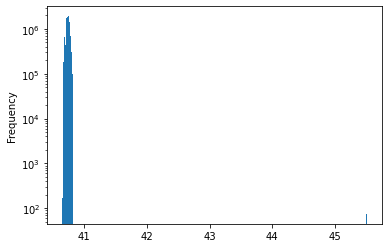

In [36]:
data["start station latitude"].plot(kind="hist",logy = True,bins=600)

There appear to be around a 100 bikes lost at latitude > 45, which is somewhere around Montreal.
We exclude these.

In [ ]:
lost = data["start latitude "]

We now split the data in a 60/20/20 ratio of training/validation/test.

In [8]:
print(len(data))
n = len(data)
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
train_size = int(train_ratio*n)
val_size = int(val_ratio*n)
test_size = int(test_ratio*n)
print("Train: {0}, Val: {1}, Test: {2}".format(int(train_ratio*n), int(val_ratio*n), int(test_ratio*n)))

17548339
Train: 10529003, Val: 3509667, Test: 3509667


In [9]:
trainset,testset = train_test_split(data,test_size=test_size)
trainset,valset = train_test_split(trainset,test_size=val_size)
print(len(trainset),len(valset),len(testset))

10529005 3509667 3509667


In [10]:
with open("Data/Train.csv","w") as file:
    trainset.to_csv(file)

In [11]:
with open("Data/Validation.csv","w") as file:
    valset.to_csv(file)

In [12]:
with open("Data/Test.csv","w") as file:
    testset.to_csv(file)